In [1]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
# Load the CSV files into dataframes
dataframes = {}
keys = [str(i).zfill(2) for i in range(1, 13)] # strings '01' to '12'
for key in keys:
    df = pd.read_csv(f'CSVafterClean/{key}.csv')
    dataframes[key] = df


In [3]:
# Create an empty list to store the concatenated data
concatenated_data = []
for i in dataframes:
    df = dataframes[i]
    # Add a 'Month' column to each dataframe
    snip = df.loc[:, df.columns.isin(['time', 'prcp_total'])]
    concatenated_data.append(snip)
    
# Concatenate dataframes vertically
combined_df = pd.concat(concatenated_data, ignore_index=True) #size is [101835 rows x 2 columns]

# Convert 'time' column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

print(aggregated_df)



           time  prcp_total
0    2015-01-01    1.136654
1    2015-01-02    0.258093
2    2015-01-03    0.274102
3    2015-01-04    0.086851
4    2015-01-05    0.565326
..          ...         ...
360  2015-12-27    0.192383
361  2015-12-28    0.392772
362  2015-12-29    0.158494
363  2015-12-30    1.181893
364  2015-12-31    0.337404

[365 rows x 2 columns]


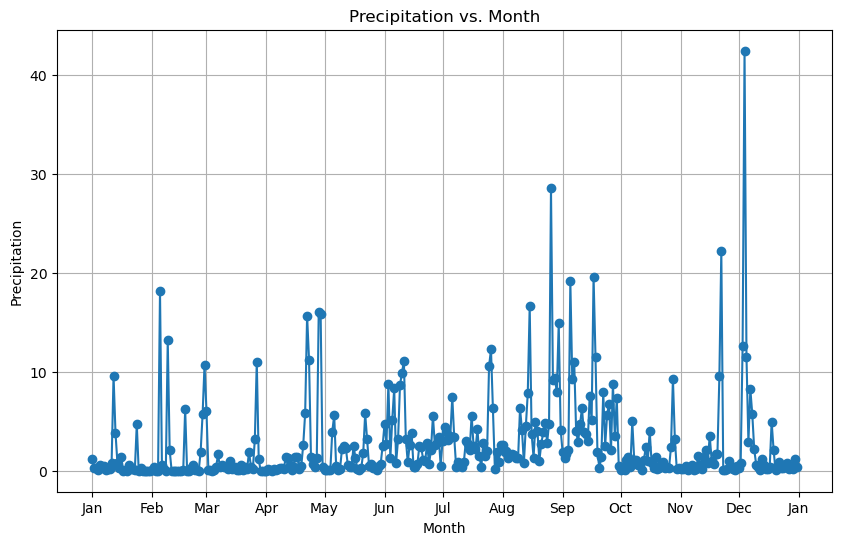

In [4]:
# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df['time'], aggregated_df['prcp_total'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.title('Precipitation vs. Month')
plt.grid(True)

# Format the x-axis ticks to show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set tick interval to 1 month

plt.show()

In [5]:
# Assuming 'dataframes' is your dictionary of dataframes
# Extract the 'prcp_total' column from each dataframe
X = []  # Input features
y = []  # Target variable

for key, df in dataframes.items():
     # Select all columns except 'time', and 'prcp_total' temporal aspects
    features = df.loc[:, ~df.columns.isin(['lat','lon','time', 'next_day_prcp_total'])].values
    X.append(features) #a list of arrays, where each array represents the features for one dataframe. These arrays have the same number of columns (features).
    y.append(df['next_day_prcp_total'].values) #a list of 1D NumPy arrays, where each array represents the 'prcp_total' values (target variable) for one dataframe

# Combine data from all dataframes
X = np.vstack(X) #vertically stacks (concatenates) these arrays on top of each other, effectively combining into a single 2D NumPy array of input features.
#where each row represents a data point (sample), and each column represents a feature.
y = np.concatenate(y) # y becomes a 1D array of target data point values of the one target variable


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (optional but often recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Build your neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {loss}")

Epoch 1/10
2546/2546 [==============================] - 3s 947us/step - loss: 20.5919 - val_loss: 18.0335
Epoch 2/10
2546/2546 [==============================] - 2s 900us/step - loss: 15.8689 - val_loss: 14.3026
Epoch 3/10
2546/2546 [==============================] - 2s 902us/step - loss: 13.0988 - val_loss: 11.8815
Epoch 4/10
2546/2546 [==============================] - 2s 887us/step - loss: 11.3631 - val_loss: 10.7522
Epoch 5/10
2546/2546 [==============================] - 2s 877us/step - loss: 10.2399 - val_loss: 10.0290
Epoch 6/10
2546/2546 [==============================] - 2s 925us/step - loss: 9.4969 - val_loss: 9.1951
Epoch 7/10
2546/2546 [==============================] - 2s 905us/step - loss: 8.9540 - val_loss: 9.2550
Epoch 8/10
2546/2546 [==============================] - 2s 905us/step - loss: 8.3934 - val_loss: 8.8187
Epoch 9/10
2546/2546 [==============================] - 2s 889us/step - loss: 8.0280 - val_loss: 8.3954
Epoch 10/10
637/637 [==============================] -

In [8]:
#Shape Check
print(f"Shape of y: {y.shape}, shape of X: {X.shape}")
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")
num_samples = X.shape[0]
print(f"Number of data points in X: {num_samples}")

Shape of y: (101835,), shape of X: (101835, 44)
Number of features in X: 44
Number of data points in X: 101835


In [9]:
X_train

array([[ 1.17601825,  1.46330442,  0.7429586 , ...,  0.91691958,
         0.76718381, -0.60413055],
       [ 1.28664622,  0.91368946,  1.53835749, ...,  0.69177984,
         0.60181778, -1.50578003],
       [-0.48153499, -0.51376216, -0.70567777, ...,  0.26653234,
         0.28248931, -0.2753712 ],
       ...,
       [ 0.49112688, -0.02061638,  0.84900938, ..., -4.05702399,
        -4.10302201,  1.26034219],
       [-0.63295261, -1.30878615, -0.25395839, ..., -0.77725295,
        -0.64836785,  1.32226067],
       [-2.04781682, -2.36798131, -1.49133754, ...,  1.4997885 ,
         1.45988599,  2.02193189]])

In [10]:
y_train

array([0.6305965 , 0.23723405, 0.00297182, ..., 0.30470402, 0.00081104,
       0.04125093])

In [11]:
# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2880      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mm]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


....................................................................................................
....................

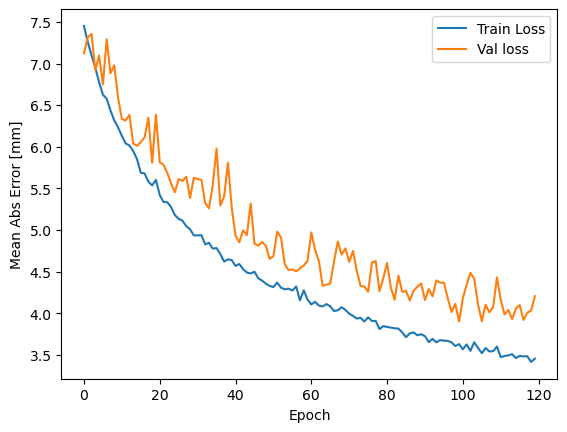

In [13]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(X_train, y_train, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [14]:
# Calculate MAE separately
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae} millimeters")

637/637 [==============================] - 0s 564us/step
Mean Absolute Error on Test Set: 1.2709391998011075 millimeters


637/637 [==============================] - 0s 536us/step


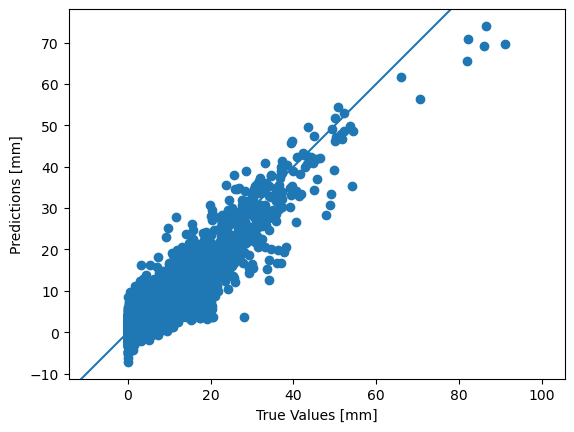

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [16]:
np.corrcoef(y_test,test_predictions)[0,1]

0.9236966106471249

In [17]:
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions)

0.8511783102473665

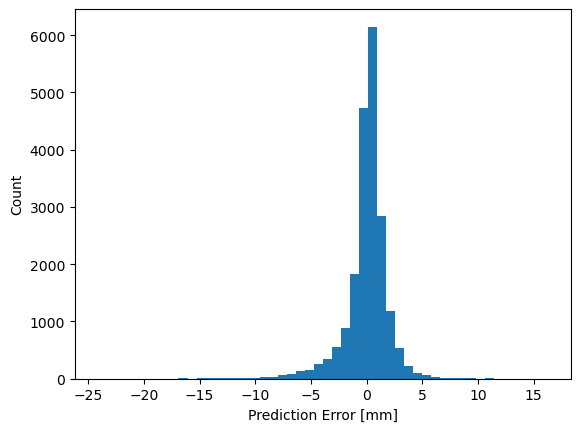

In [18]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mm]")
_ = plt.ylabel("Count")